# Виконала студентка ІП-13 Лисенко Анастасія

# Лабораторна робота №7

1. Побудувати та проаналізувати часовий ряд для статистики захворювань на Covid в двох сусідніх країнах по вашому вибору (дані взяти в інтернеті).
2. Побудувати та проаналізувати часовий ряд для курсу гривня/долар або гривня/євро за останні 3 роки (дані взяти в інтернеті).

Встановлюємо потрібні бібліотеки

In [163]:
!pip install numpy pandas matplotlib statsmodels -q

You should consider upgrading via the 'D:\DA\LAB_7\venv\Scripts\python.exe -m pip install --upgrade pip' command.


Зчитуємо файл та працюємо з його структурою, вирізаємо непотрібні дані та непотрібні країни. В нашому досліді братимуть участь Україна та Польша.

In [164]:
import pandas as pd
data = pd.read_csv("data/owid-covid-data.csv")

# retrieving row by loc method
df = data.loc[data['location'].isin(['Ukraine', 'Poland'])]

# Select only the desired columns
df = df.loc[:, ['location', 'date', 'total_cases', 'new_cases']]

# Pivot the data to get separate columns for each country
df_pivot = df.pivot(index='date', columns='location')

# Rename the columns to include the country name
df_pivot.columns = [f"{col[0]}_{col[1].lower()}" for col in df_pivot.columns]
# We have only 2 Nans and in the beginning of our data, so we replace it with 0
df_pivot.fillna(0, inplace=True)

df_pivot = df_pivot.reset_index()
df_pivot['date'] = pd.to_datetime(df_pivot['date'])

df_pivot.to_csv('data/covid_ua_pl.csv', index=False)
df_pivot

,date,total_cases_poland,total_cases_ukraine,new_cases_poland,new_cases_ukraine
0,2020-03-03,0.0,1.0,0.0,1.0
1,2020-03-04,1.0,1.0,1.0,0.0
2,2020-03-05,1.0,1.0,0.0,0.0
3,2020-03-06,5.0,1.0,4.0,0.0
4,2020-03-07,5.0,1.0,0.0,0.0
...,...,...,...,...,...
728,2022-03-01,5680034.0,5040518.0,12980.0,0.0
729,2022-03-02,5694767.0,5040518.0,14733.0,0.0
730,2022-03-03,5708827.0,5040518.0,14060.0,0.0
731,2022-03-04,5721316.0,5040518.0,12489.0,0.0


Аналізуємо дані

In [165]:
df_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 733 entries, 0 to 732
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 733 non-null    datetime64[ns]
 1   total_cases_poland   733 non-null    float64       
 2   total_cases_ukraine  733 non-null    float64       
 3   new_cases_poland     733 non-null    float64       
 4   new_cases_ukraine    733 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 28.8 KB


In [166]:
df_pivot.describe()

,date,total_cases_poland,total_cases_ukraine,new_cases_poland,new_cases_ukraine
count,733,7.330000e+02,7.330000e+02,733.000000,733.000000
mean,2021-03-04 00:00:00.000000256,1.859455e+06,1.619035e+06,7822.702592,6876.559345
min,2020-03-03 00:00:00,0.000000e+00,1.000000e+00,0.000000,0.000000
25%,2020-09-02 00:00:00,6.851700e+04,1.288330e+05,352.000000,1048.000000
50%,2021-03-04 00:00:00,1.750659e+06,1.422927e+06,2236.000000,3889.000000
75%,2021-09-03 00:00:00,2.889773e+06,2.393002e+06,12725.000000,10138.000000
max,2022-03-05 00:00:00,5.734041e+06,5.040518e+06,57659.000000,45022.000000
std,NaN,1.604101e+06,1.428374e+06,10537.865460,8075.914105


Будуємо лінійний графік із двома лініями, однією для стовпця «new_cases_poland», а іншою — для стовпця «new_cases_ukraine», проти значень осі X зі стовпця «date».

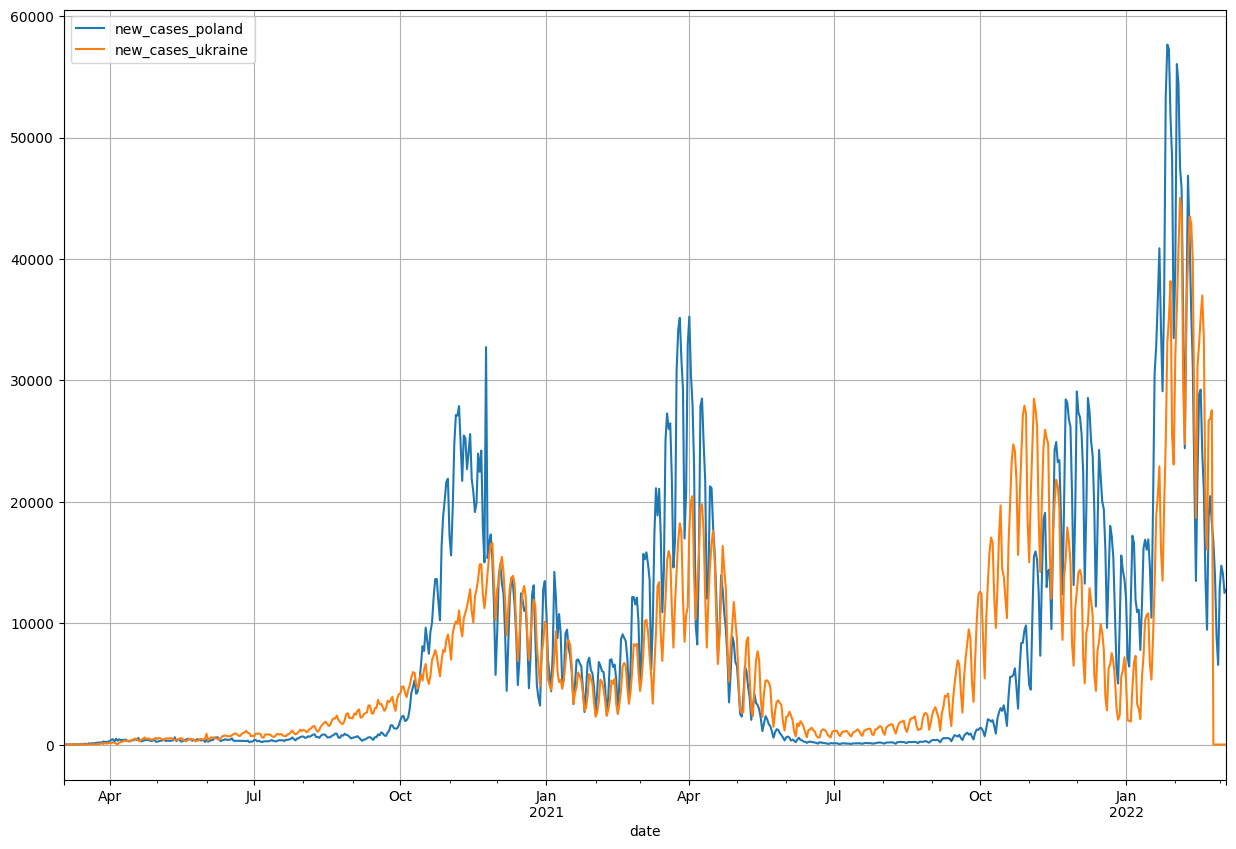

In [167]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(15, 10))
df_pivot.plot(x="date", y=["new_cases_poland", "new_cases_ukraine"], ax=ax)
ax.grid()
plt.show()


Будуємо гістограми для тих самих значень

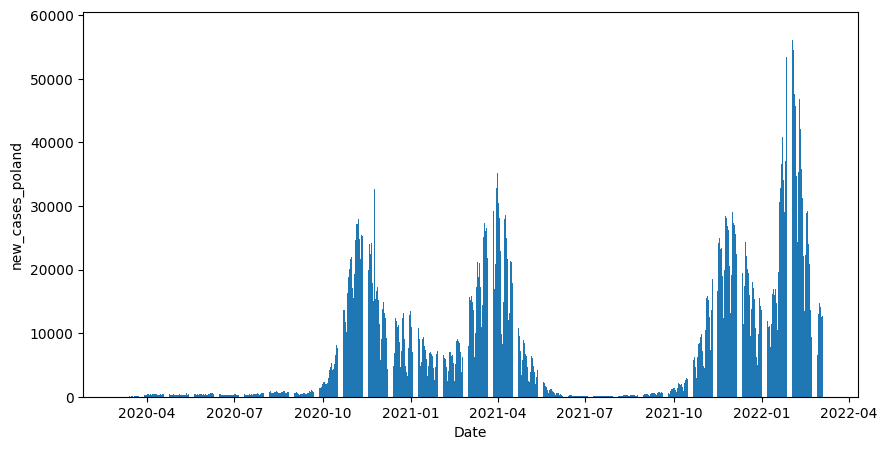

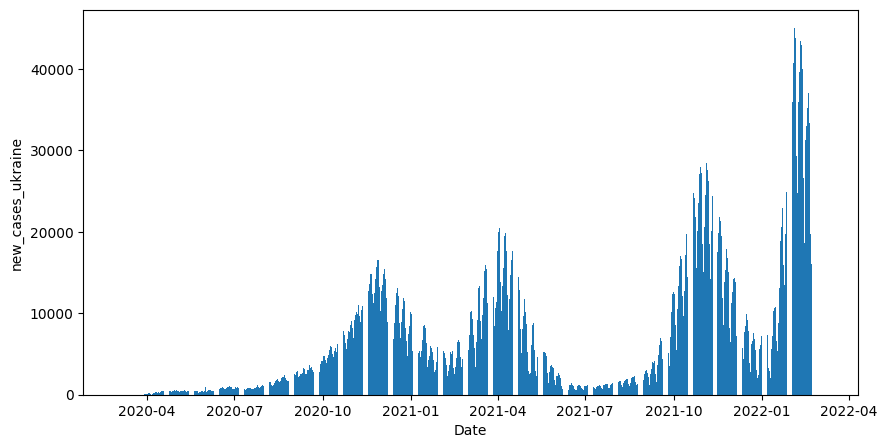

In [168]:
def show_column_hist(dataset, column, date_column):
    column_data = dataset[column]
    fig, ax = plt.subplots(figsize=(10,5))
    ax.bar(dataset[date_column], column_data.values)
    ax.set_xlabel("Date")
    ax.set_ylabel(column)
    plt.show()

show_column_hist(df_pivot, "new_cases_poland", 'date')
show_column_hist(df_pivot, "new_cases_ukraine", 'date')


Будуємо рухомі середні. Обчислюємо їх тут для згладжування раптових коливань та підкреслення довготермінових трендів та циклів. Також задаємо різні розміри підмножини обчислювальних значень.

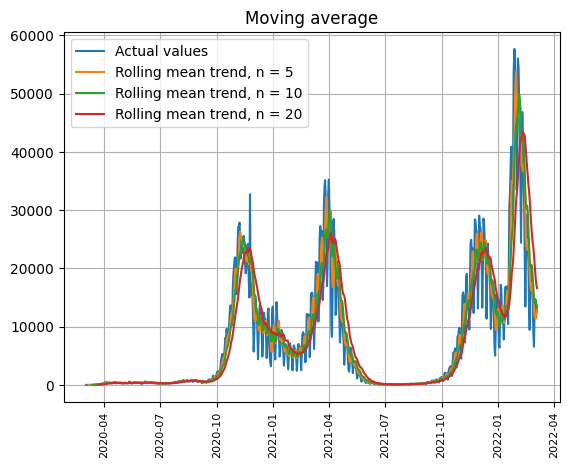

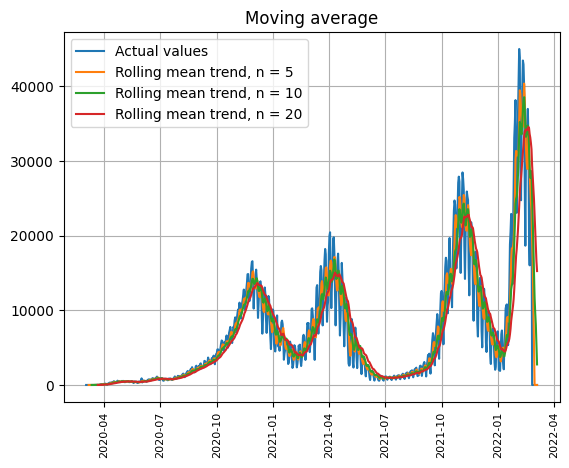

In [169]:
def plot_moving_average(dataset , column , windows, date_column ):
    rolling_means = [(dataset[column].rolling(window=n).mean(), n) for n in windows]
    plt.title(f"Moving average")
    plt.plot(dataset[date_column], dataset[column], label="Actual values")
    for rolling_mean, window in rolling_means:
        plt.plot(dataset[date_column],rolling_mean, label=f"Rolling mean trend, n = {window}")
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.xticks(rotation=90, fontsize=8)
    plt.show()

plot_moving_average(df_pivot, "new_cases_poland", [5, 10, 20], 'date')
plot_moving_average(df_pivot, "new_cases_ukraine", [5, 10, 20], 'date')


Розкладаємо задані стовпці набору даних на сезонні, трендові та залишкові компоненти.

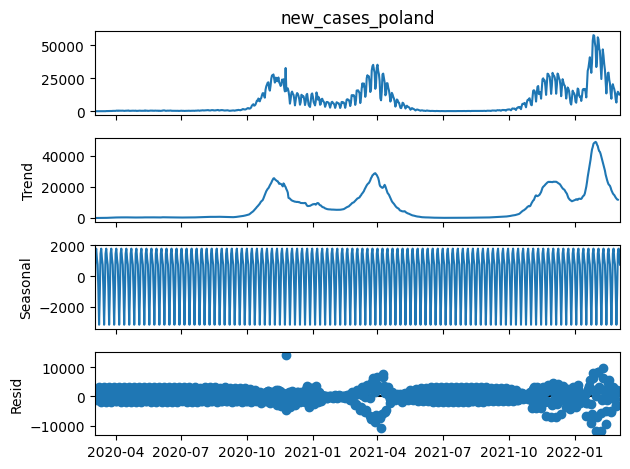

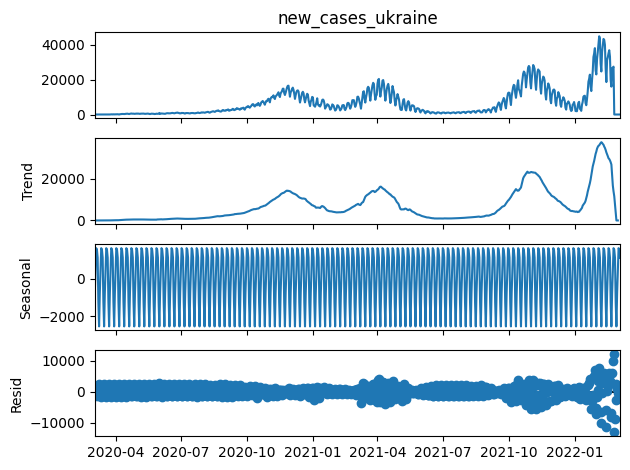

In [170]:
import statsmodels.tsa.api as smt

def plot_seasonal_decompose(dataset , column):
    decomposition = smt.seasonal_decompose(dataset[column])
    decomposition.plot()
    plt.show()

df_pivot = df_pivot.set_index('date')
df_pivot.index = pd.to_datetime(df_pivot.index)
plot_seasonal_decompose(df_pivot, "new_cases_poland")
plot_seasonal_decompose(df_pivot, "new_cases_ukraine")


Будуємо кореляцію часових рядів для кожної країни (Польща та Україна) за допомогою автокореляційної функції (ACF) і часткової автокореляційної функції (PACF). Можемо відслідкувати певний цикл розміром в 7(днів), що може означати що дані мають тижневу деталізацію.

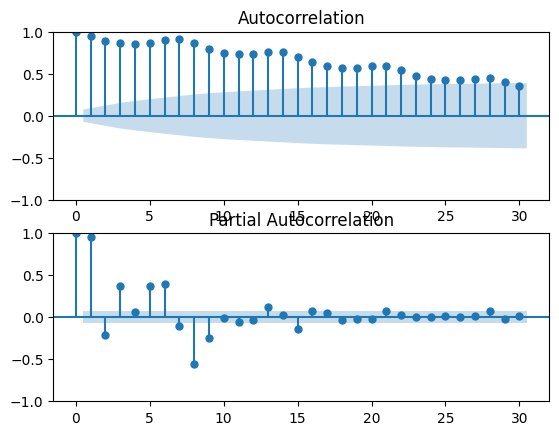

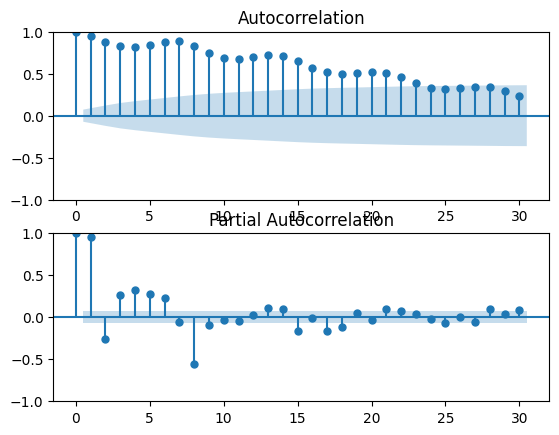

In [171]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
def plot_correlation(dataset, column : str):
    _, ax = plt.subplots(2)
    ax[0] = plot_acf(dataset[column], ax=ax[0], lags=30)
    ax[1] = plot_pacf(dataset[column], ax=ax[1], lags=30)
    plt.show()

plot_correlation(df_pivot, "new_cases_poland")
plot_correlation(df_pivot, "new_cases_ukraine")


Виконуємо тест Дікі-Фуллера на стаціонарність та бачимо, що обидва набори даних стаціонарні.

In [172]:
def dickey_fuller_test(dataset , column : str):
    test = smt.adfuller(dataset[column], autolag="AIC")
    print("adf: ", test[0])
    print("p-value: ", test[1])
    print("Critical values: ", test[4])
    return test[0] <= test[4]["5%"]

print(dickey_fuller_test(df_pivot, "new_cases_poland"))
print(dickey_fuller_test(df_pivot, "new_cases_ukraine"))


adf:  -3.169936006421573
p-value:  0.02179219692662127
Critical values:  {'1%': -3.439516060164992, '5%': -2.8655850998755263, '10%': -2.5689240826597173}
True
adf:  -4.747762443665012
p-value:  6.838317888196062e-05
Critical values:  {'1%': -3.4395677423210493, '5%': -2.8656078730509784, '10%': -2.5689362152032573}
True


Зчитуємо дані та сортуємо їх

In [173]:
rates_data = pd.read_csv("data/HistoricalPrices.csv")
rates_data['Date'] = pd.to_datetime(rates_data['Date'], format='%m/%d/%y')
rates_data = rates_data.sort_values('Date')
rates_data

,Date,Open,High,Low,Close
780,2020-05-11,26.8383,26.8487,26.8333,26.8487
779,2020-05-12,26.8487,26.9102,26.7696,26.7696
778,2020-05-13,26.7696,26.7696,26.6815,26.6815
777,2020-05-14,26.6815,26.6919,26.6815,26.6919
776,2020-05-15,26.6919,26.6919,26.6262,26.6262
...,...,...,...,...,...
4,2023-05-02,36.9500,37.0500,36.7500,36.8500
3,2023-05-03,36.8500,37.0500,36.6500,36.9500
2,2023-05-04,36.9500,37.0500,36.8500,36.9500
1,2023-05-05,36.9500,37.1500,36.8500,36.9500


Аналізуємо дані

In [174]:
rates_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 781 entries, 780 to 0
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    781 non-null    datetime64[ns]
 1    Open   781 non-null    float64       
 2    High   781 non-null    float64       
 3    Low    781 non-null    float64       
 4    Close  781 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 36.6 KB


In [175]:
rates_data.describe()

,Date,Open,High,Low,Close
count,781,781.000000,781.000000,781.000000,781.000000
mean,2021-11-07 04:49:28.501920512,30.298792,30.446511,30.162724,30.311616
min,2020-05-11 00:00:00,26.150000,26.250000,25.950000,26.150000
25%,2021-02-08 00:00:00,27.350000,27.550000,27.250000,27.350000
50%,2021-11-08 00:00:00,28.250000,28.350000,28.150000,28.250000
75%,2022-08-08 00:00:00,36.750000,36.850000,36.650000,36.750000
max,2023-05-08 00:00:00,37.050000,37.450000,36.950000,37.050000
std,NaN,4.045868,4.062799,4.041251,4.051021


Будуємо граф і бачимо великий і різкий стрибок у рості курсу приблизно у кінці липня в з'язку з корегування НБУ офіційного курсу гривні до долара США на 25% до 36,5686 грн/дол.

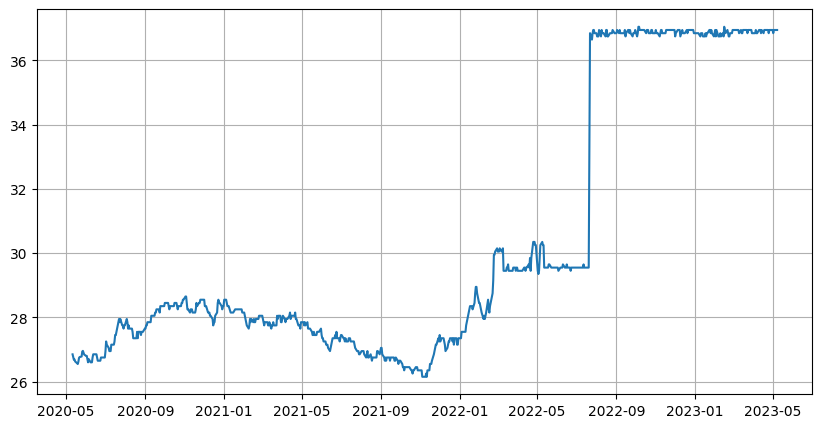

In [176]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(rates_data["Date"], rates_data[" Close"])
ax.grid()
plt.show()

При побудові гістограми бачимо таку ж динаміку

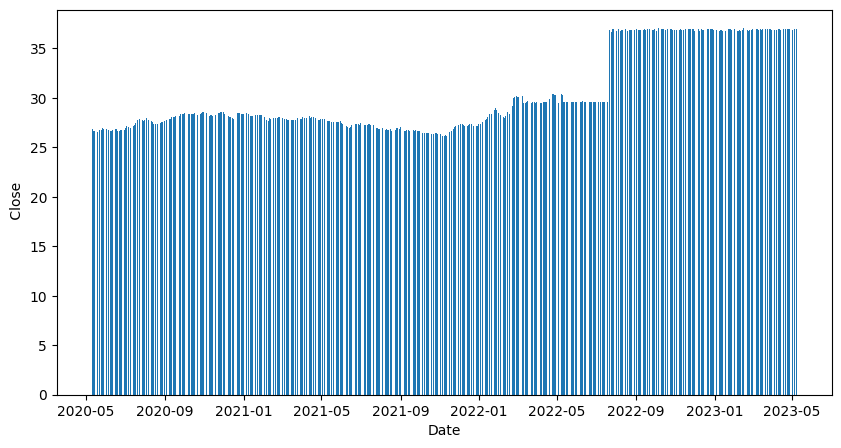

In [177]:
show_column_hist(rates_data, " Close", "Date")

Тепер використаємо згладжування для дослідження характеристик ряду.

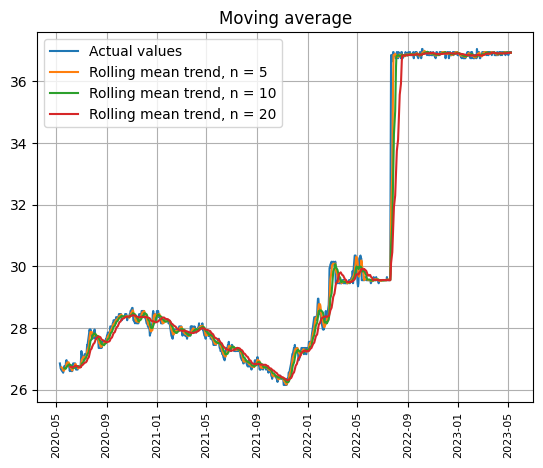

In [178]:
plot_moving_average(rates_data, " Close", [5, 10, 20], "Date")

Давайте декомпозуємо ціну на тренд, сезонність та залишки.

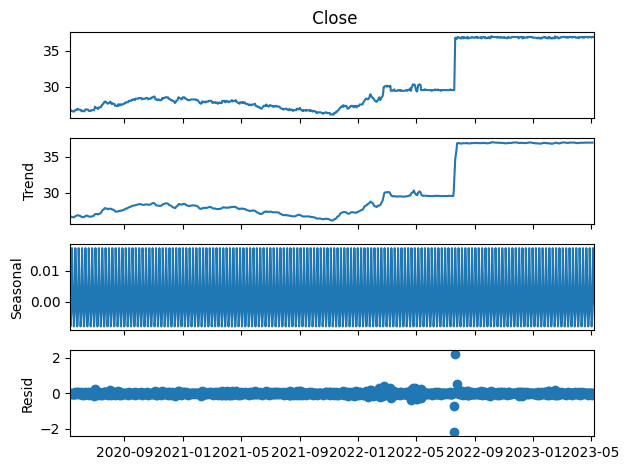

In [179]:
rates_data = rates_data.set_index('Date')
rates_data.index = pd.to_datetime(rates_data.index)
plot_seasonal_decompose(rates_data, " Close")


Тепер побудуємо графіки автокореляції та часткової автокореляції.

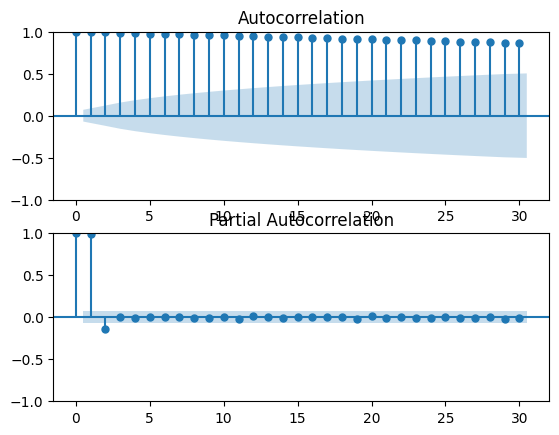

In [180]:
plot_correlation(rates_data, " Close")


Оскільки абсолютне значення тестової статистики ADF перевищує критичні значення, ми не можемо відхилити нульову гіпотезу про те, що часовий ряд є нестаціонарним. Крім того, оскільки p-значення більше 0,05, ми не можемо відхилити нульову гіпотезу. Таким чином, ми зробили б висновок, що "Close" часовий ряд є нестаціонарним.

In [181]:
print(dickey_fuller_test(rates_data, " Close"))


adf:  -0.4650805987362106
p-value:  0.8986525448352936
Critical values:  {'1%': -3.438783171038672, '5%': -2.865262118650577, '10%': -2.568752018688748}
False
